In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM_0D as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM_0D as tp_lc_functions

import os
os.mkdir('TNG-SIM_images/v19_RF_FeatRank_0D')

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 6 of the dataset that includes Mvir in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v6_TNG-SIM_0D_Dataset_wMvir.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

SubhaloBHMass_log  SubhaloBHMdot_log  SubhaloGasMetallicity_log  \
0           9.998109          -3.400095                  -2.112483   
1           9.898275          -4.012083                  -2.359742   

   SubhaloSFRinRad_log  SubhaloStarMetallicity_log  SubhaloVelDisp_log  \
0            -0.708133                   -1.543295            2.780947   
1             0.219496                   -1.679031            2.774496   

   SubhaloVmax_log  SubhaloVmaxRad_log  SubhaloRgas_log  SubhaloRstar_log  \
0         2.999733            2.668073         2.949910          1.828096   
1         2.981978            3.134860         2.988572          2.098578   

   SubhaloMgas_log  SubhaloMstar_log  GroupNsubs_log  Group_M_TopHat200_log  \
0        13.092064         12.497443        4.235150              14.646987   
1        13.610459         12.316876        4.150971              14.687475   

   Group_R_TopHat200_log  SubhaloMHI_log  SubhaloMH2_log  \
0               3.292134       10.061858       10.043734   
1               3.305635        9.899765        9.955786   

   Group_V_TopHat200_log  GroupSpin_dmo_log  
0               2.994161          -1.769689  
1               3.007654          -1.893303

In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 17)

In [10]:
df_0D.shape

(21598, 17)

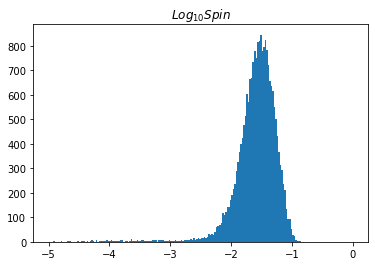

In [13]:
plt.hist(df_raw_log.GroupSpin_dmo_log, bins=200, range=(-5, 0))
plt.title(r'$Log_{10}Spin$')
plt.show()

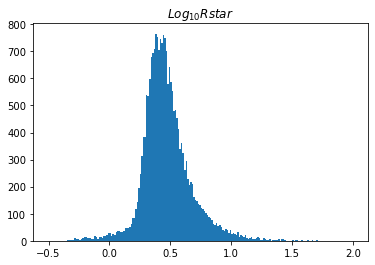

In [14]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, range=(-0.5, 2.0))
plt.title(r'$Log_{10}Rstar$')
plt.show()

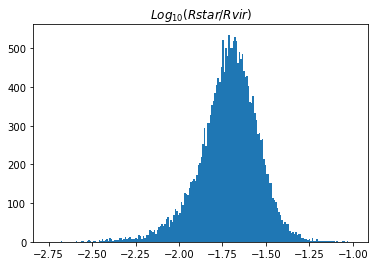

In [15]:
plt.hist(df_0D_log.SubhaloRstar_hs_log, bins=200, range=(-2.75, -1.0))
plt.title(r'$Log_{10}(Rstar/Rvir)$')
plt.show()

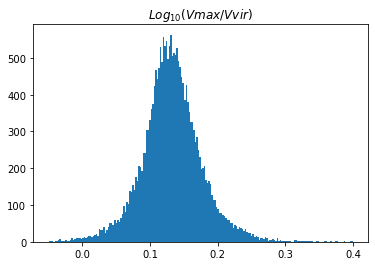

In [16]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200, range=(-0.05, 0.4))
plt.title(r'$Log_{10}(Vmax/Vvir)$')
plt.show()

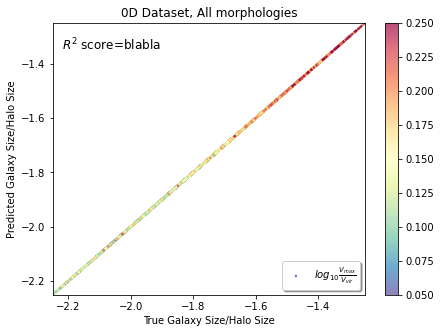

In [17]:
# Plot of 0D log10 Rstar vs 0D log10 Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, df_0D_log.SubhaloRstar_hs_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.22, -1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
# ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title(r'0D Dataset, All morphologies')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

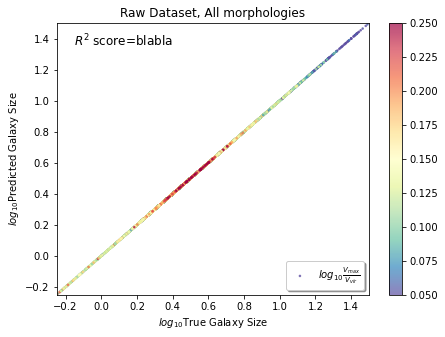

In [18]:
# Plot of log10 Raw Rstar vs log10 Raw Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, df_raw_log.SubhaloRstar_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, All morphologies')
ax.set_xlabel(r'$log_{10}$True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel(r'$log_{10}$Predicted Galaxy Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

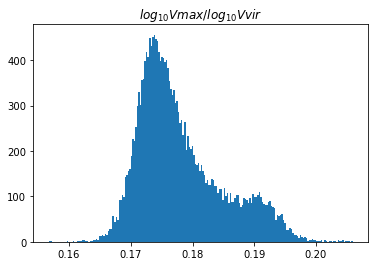

In [19]:
plt.hist(df_raw_log.SubhaloVmax_log/df_raw_log.Group_M_TopHat200_log, bins=200)
plt.title(r'$log_{10}Vmax/log_{10}Vvir$')
plt.show()

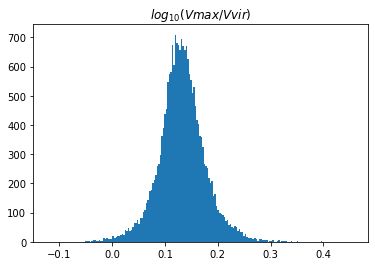

In [20]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200)
plt.title(r'$log_{10}(Vmax/Vvir)$')
plt.show()

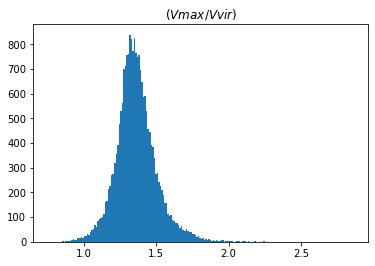

In [21]:
plt.hist(df_0D.SubhaloVmax_hs, bins=200)
plt.title(r'$(Vmax/Vvir)$')
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset: RF & Feature Ranking

In [22]:
X_all = df_0D_log.drop(columns=['SubhaloRstar_hs_log'])
 

y_all = df_0D_log.loc[:,'SubhaloRstar_hs_log']

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.8105 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}
RF Accuracy: 0.81 (+/- 0.02)


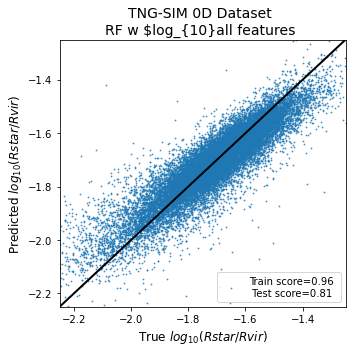

Elapsed time to compute the importances: 0.191 seconds
Elapsed time to compute the importances: 80.410 seconds


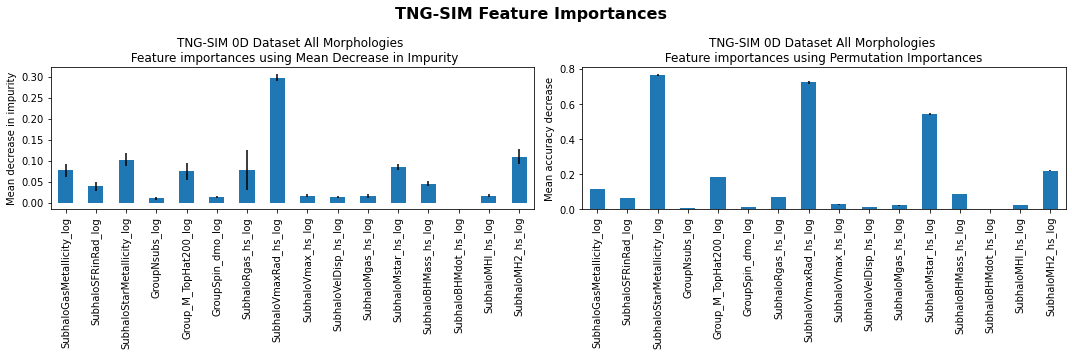

  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, mi

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, mi

  6%|██▋                                        | 1/16 [01:53<28:19, 113.30s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, mi

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

 12%|█████▍                                     | 2/16 [03:45<26:13, 112.42s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

 19%|████████                                   | 3/16 [05:38<24:28, 112.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 25%|███████████                                 | 4/16 [06:15<16:34, 82.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.7s


 31%|█████████████▊                              | 5/16 [08:09<17:13, 93.97s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=N

 38%|████████████████▏                          | 6/16 [10:27<18:10, 109.08s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=2, 

 44%|██████████████████▊                        | 7/16 [12:27<16:55, 112.80s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=2

 50%|█████████████████████▌                     | 8/16 [14:42<15:58, 119.83s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=Non

 56%|████████████████████████▏                  | 9/16 [16:52<14:20, 122.92s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_featur

 62%|██████████████████████████▎               | 10/16 [19:03<12:33, 125.52s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=No

 69%|████████████████████████████▉             | 11/16 [21:03<10:19, 123.82s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_fea

 75%|███████████████████████████████▌          | 12/16 [23:21<08:32, 128.14s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=N

 81%|██████████████████████████████████▏       | 13/16 [25:29<06:23, 127.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 88%|█████████████████████████████████████▋     | 14/16 [25:47<03:09, 94.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=No

 94%|███████████████████████████████████████▍  | 15/16 [27:47<01:42, 102.33s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=2, 

100%|██████████████████████████████████████████| 16/16 [29:51<00:00, 111.94s/it]


1. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=s

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  19.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=N

  7%|██▊                                        | 1/15 [02:42<37:48, 162.02s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.5s


 13%|█████▋                                     | 2/15 [05:19<34:34, 159.60s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  19.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=N

 20%|████████▌                                  | 3/15 [07:59<31:55, 159.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=N

 27%|███████████▍                               | 4/15 [10:03<26:39, 145.39s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=No

 33%|██████████████▎                            | 5/15 [12:39<24:54, 149.49s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=No

 40%|█████████████████▏                         | 6/15 [15:47<24:20, 162.32s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  22.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=No

 47%|████████████████████                       | 7/15 [18:31<21:44, 163.10s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  19.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=N

 53%|██████████████████████▉                    | 8/15 [21:07<18:45, 160.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_fea

 60%|█████████████████████████▊                 | 9/15 [23:43<15:55, 159.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total ti

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=

 67%|████████████████████████████              | 10/15 [26:09<12:55, 155.11s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=No

 73%|██████████████████████████████▊           | 11/15 [28:47<10:24, 156.17s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.8s


 80%|█████████████████████████████████▌        | 12/15 [31:24<07:48, 156.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=au

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.3s


 87%|████████████████████████████████████▍     | 13/15 [33:35<04:57, 148.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_feature

 93%|███████████████████████████████████████▏  | 14/15 [36:10<02:30, 150.47s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=N

100%|██████████████████████████████████████████| 15/15 [38:41<00:00, 154.75s/it]


2. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=No

  7%|███                                        | 1/14 [02:58<38:36, 178.19s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total ti

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.9s


 14%|██████▏                                    | 2/14 [05:53<35:16, 176.37s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featu

 21%|█████████▏                                 | 3/14 [08:50<32:23, 176.68s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s


 29%|████████████▎                              | 4/14 [11:24<27:59, 167.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

 36%|███████████████▎                           | 5/14 [14:24<25:48, 172.02s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  22.4s
[CV] END bootstrap=True, max_depth=N

 43%|██████████████████▍                        | 6/14 [17:31<23:38, 177.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  27.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=No

 50%|█████████████████████▌                     | 7/14 [20:43<21:13, 181.91s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

 57%|████████████████████████▌                  | 8/14 [23:58<18:37, 186.31s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.6s


 64%|███████████████████████████▋               | 9/14 [27:15<15:47, 189.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, m

 71%|██████████████████████████████            | 10/14 [30:28<12:42, 190.73s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, 

 79%|█████████████████████████████████         | 11/14 [33:37<09:29, 189.96s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  22.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=No

 86%|████████████████████████████████████      | 12/14 [36:48<06:20, 190.30s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, 

 93%|███████████████████████████████████████   | 13/14 [39:22<02:59, 179.44s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=2, max_feat

100%|██████████████████████████████████████████| 14/14 [42:35<00:00, 182.53s/it]


3. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  30.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=No

  8%|███▎                                       | 1/13 [04:13<50:45, 253.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  30.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  28.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.9s
[CV] END bootstrap=True, max_depth=2, max_features

 15%|██████▌                                    | 2/13 [08:22<46:00, 250.94s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  30.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  27.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_fe

 23%|█████████▉                                 | 3/13 [12:07<39:48, 238.80s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  24.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  30.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.1s
[CV] END bootstrap=True, max_depth=No

 31%|█████████████▏                             | 4/13 [16:18<36:35, 243.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  30.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=No

 38%|████████████████▌                          | 5/13 [20:34<33:04, 248.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  28.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  29.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=No

 46%|███████████████████▊                       | 6/13 [24:45<29:03, 249.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  29.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  30.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=No

 54%|███████████████████████▏                   | 7/13 [28:57<25:01, 250.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

 62%|██████████████████████████▍                | 8/13 [33:13<21:00, 252.06s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total ti

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  30.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  28.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  31.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END bootstrap=True, max_depth=No

 69%|█████████████████████████████▊             | 9/13 [37:32<16:55, 254.00s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  27.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=No

 77%|████████████████████████████████▎         | 10/13 [41:38<12:35, 251.78s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  29.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 85%|███████████████████████████████████▌      | 11/13 [45:54<08:26, 253.05s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  31.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  28.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  22.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

 92%|██████████████████████████████████████▊   | 12/13 [49:22<03:59, 239.17s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features

100%|██████████████████████████████████████████| 13/13 [53:36<00:00, 247.44s/it]


4. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934


  0%|                                                    | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  34.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=No

  8%|███▌                                       | 1/12 [04:35<50:34, 275.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time= 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

 17%|███████▏                                   | 2/12 [09:09<45:42, 274.28s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  32.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  32.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

 25%|██████████▊                                | 3/12 [13:23<39:48, 265.38s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  30.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estima

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=2,

 33%|██████████████▎                            | 4/12 [18:17<36:53, 276.74s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  35.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  32.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=No

 42%|█████████████████▉                         | 5/12 [22:54<32:17, 276.78s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=Non

 50%|█████████████████████▌                     | 6/12 [27:30<27:37, 276.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.7s
[CV] END bootstrap=True, max_depth=2, max

 58%|█████████████████████████                  | 7/12 [32:08<23:04, 276.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, m

 67%|████████████████████████████▋              | 8/12 [36:50<18:33, 278.42s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=No

 75%|████████████████████████████████▎          | 9/12 [41:31<13:57, 279.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  35.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  33.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=No

 83%|███████████████████████████████████       | 10/12 [46:09<09:18, 279.07s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  35.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  32.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

 92%|██████████████████████████████████████▌   | 11/12 [50:02<04:24, 264.91s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  33.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.6s


100%|██████████████████████████████████████████| 12/12 [54:44<00:00, 273.67s/it]


5. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872


  0%|                                                    | 0/11 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  35.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  33.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=No

  9%|███▉                                       | 1/11 [05:27<54:39, 327.94s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  38.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=N

 18%|███████▊                                   | 2/11 [10:50<48:42, 324.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  36.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  33.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  38.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=No

 27%|███████████▋                               | 3/11 [15:51<41:50, 313.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  42.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=N

 36%|███████████████▋                           | 4/11 [21:16<37:09, 318.44s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=N

 45%|███████████████████▌                       | 5/11 [26:37<31:56, 319.42s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  38.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  41.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=No

 55%|███████████████████████▍                   | 6/11 [32:03<26:46, 321.36s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  42.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  38.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=

 64%|███████████████████████████▎               | 7/11 [37:27<21:29, 322.44s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  38.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  41.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  39.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max

 73%|███████████████████████████████▎           | 8/11 [42:53<16:10, 323.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=N

 82%|███████████████████████████████████▏       | 9/11 [48:17<10:47, 323.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  38.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  35.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=No

 91%|██████████████████████████████████████▏   | 10/11 [52:57<05:10, 310.16s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  35.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=N

100%|██████████████████████████████████████████| 11/11 [58:21<00:00, 318.31s/it]


6. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872
	 6 SubhaloSFRinRad_log 0.7905678769630443


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  47.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=N

 10%|████▎                                      | 1/10 [05:56<53:25, 356.19s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=N

 20%|████████▌                                  | 2/10 [11:31<45:53, 344.14s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  44.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  47.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=2, max_fea

 30%|████████████▉                              | 3/10 [17:28<40:48, 349.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  47.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  44.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  46.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=N

 40%|█████████████████▏                         | 4/10 [23:22<35:08, 351.49s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  43.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  44.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  40.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  47.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  46.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  44.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=No

 50%|█████████████████████▌                     | 5/10 [29:20<29:29, 353.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  46.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  44.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_fe

 60%|█████████████████████████▊                 | 6/10 [35:15<23:36, 354.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  44.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  43.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_fe

 70%|██████████████████████████████             | 7/10 [41:09<17:42, 354.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  19.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] E

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2,

 80%|██████████████████████████████████▍        | 8/10 [47:05<11:49, 354.88s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=N

 90%|██████████████████████████████████████▋    | 9/10 [52:17<05:41, 341.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  14.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  41.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  38.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  46.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=No

100%|██████████████████████████████████████████| 10/10 [58:17<00:00, 349.74s/it]


7. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872
	 6 SubhaloSFRinRad_log 0.7905678769630443
	 7 SubhaloGasMetallicity_log 0.8021514147296802


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  43.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=N

 11%|████▉                                       | 1/9 [06:07<49:00, 367.55s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  44.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  47.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  44.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  52.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=N

 22%|█████████▊                                  | 2/9 [12:32<44:05, 377.98s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  51.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=No

 33%|██████████████▋                             | 3/9 [18:55<37:59, 379.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  52.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=Non

 44%|███████████████████▌                        | 4/9 [25:23<31:55, 383.11s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  51.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  47.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  53.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  49.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=Non

 56%|████████████████████████▍                   | 5/9 [31:56<25:47, 386.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  54.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=Non

 67%|█████████████████████████████▎              | 6/9 [38:33<19:31, 390.34s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  54.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  51.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  53.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=No

 78%|██████████████████████████████████▏         | 7/9 [45:11<13:05, 392.92s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  55.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  50.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=2, max_fe

 89%|███████████████████████████████████████     | 8/9 [51:10<06:21, 381.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  54.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=Non

100%|████████████████████████████████████████████| 9/9 [57:54<00:00, 386.02s/it]


8. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872
	 6 SubhaloSFRinRad_log 0.7905678769630443
	 7 SubhaloGasMetallicity_log 0.8021514147296802
	 8 SubhaloBHMass_hs_log 0.8072384732104162


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  58.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=No

 12%|█████▌                                      | 1/8 [07:26<52:02, 446.10s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  54.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  59.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  54.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  22.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  22.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_

 25%|███████████                                 | 2/8 [15:19<46:12, 462.05s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=No

 38%|████████████████▌                           | 3/8 [23:06<38:41, 464.25s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

 50%|██████████████████████                      | 4/8 [31:01<31:13, 468.46s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=No

 62%|███████████████████████████▌                | 5/8 [38:56<23:33, 471.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=No

 75%|█████████████████████████████████           | 6/8 [46:45<15:40, 470.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_feat

 88%|██████████████████████████████████████▌     | 7/8 [53:53<07:36, 456.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  51.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  21.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  23.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=No

100%|██████████████████████████████████████████| 8/8 [1:01:48<00:00, 463.50s/it]


9. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872
	 6 SubhaloSFRinRad_log 0.7905678769630443
	 7 SubhaloGasMetallicity_log 0.8021514147296802
	 8 SubhaloBHMass_hs_log 0.8072384732104162
	 9 SubhaloVelDisp_hs_log 0.8104831446323669


  0%|                                                     | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  22.9s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  58.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=No

 14%|██████▎                                     | 1/7 [08:05<48:35, 485.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  58.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  22.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  22.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=2,

 29%|████████████▌                               | 2/7 [16:34<41:36, 499.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  12.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  26.0s
[CV] END bootstrap=True, max_depth=No

 43%|██████████████████▊                         | 3/7 [24:58<33:25, 501.36s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=Non

 57%|█████████████████████████▏                  | 4/7 [33:25<25:10, 503.56s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=No

 71%|███████████████████████████████▍            | 5/7 [41:49<16:47, 503.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=Non

 86%|█████████████████████████████████████▋      | 6/7 [49:32<08:09, 489.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  21.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  21.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=2, max_featu

100%|████████████████████████████████████████████| 7/7 [57:59<00:00, 497.07s/it]

10. iteration: 
	 1 SubhaloVmaxRad_hs_log 0.2818447274053607
	 2 SubhaloMH2_hs_log 0.4797089111098809
	 3 SubhaloStarMetallicity_log 0.5654232538758889
	 4 SubhaloMstar_hs_log 0.6987342343544934
	 5 Group_M_TopHat200_log 0.7717963710350872
	 6 SubhaloSFRinRad_log 0.7905678769630443
	 7 SubhaloGasMetallicity_log 0.8021514147296802
	 8 SubhaloBHMass_hs_log 0.8072384732104162
	 9 SubhaloVelDisp_hs_log 0.8104831446323669
	 10 SubhaloMHI_hs_log 0.81204707550488


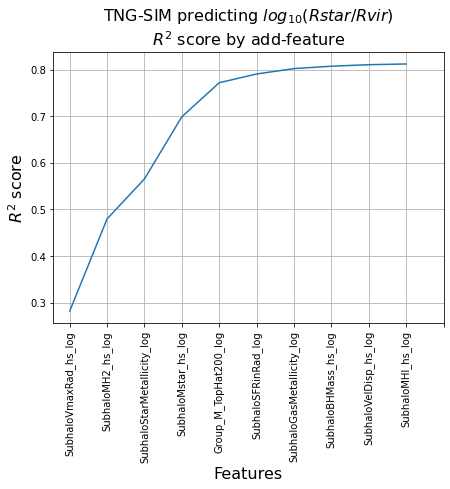

Elapsed time to run RF func on 0D TNG-SIM: 39071.502 seconds
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=No

In [23]:
# this code takes 50293.695 seconds ~ 14 hrs to run when the dataset is TNG-SIM galaxies with ~22,000 entries
# and 19 features (480 models for the RF (total 2400 fits);
# 288 models for each add-on feature ranking step, cv=3, so 864 fits )
start_time = time.time()

RF_results_all = functions.target_predicting_RF_function(X=X_all, y=y_all)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on 0D TNG-SIM: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best params, best score: 0.8105 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}

RF Accuracy: 0.81 (+/- 0.02)

<!--     n_estimators = [20, 50,100, 500, 700]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, 10, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4, 8],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True),                          verbose = 1, n_jobs = -1, return_train_score=True)

For feature ranking:

Fitting 3 folds for each of 288 candidates, totalling 864 fits

    n_estimators = [50,100, 500]
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5],
                   'n_estimators': n_estimators} -->

#### v17 The most important features, 0D Dataset (TNG100-SIM, log10features predicting log10Rstar) are:

	feature_number	features	r_sq_score
	1	SubhaloVmaxRad_hs_log	0.284638
	2	SubhaloMH2_hs_log	0.481148
	3	SubhaloStarMetallicity_log	0.563560
	4	SubhaloMstar_hs_log	0.699872
	5	SubhaloBHMass_hs_log	0.730515
	6	GroupNsubs_log	0.749827
	7	SubhaloGasMetallicity_log	0.763541
	8	SubhaloSFRinRad_log	0.778223
	9	GroupSpin_dmo_log	0.781650
	10	SubhaloVmax_hs_log	0.783478
    
### <font color='darkred'> v19 The most important features, 0D Dataset including Mvir (TNG100-SIM, log10features predicting log10Rstar) are:


    feature_number	features	r_sq_score
	1	SubhaloVmaxRad_hs_log	0.281845
	2	SubhaloMH2_hs_log	0.479709
	3	SubhaloStarMetallicity_log	0.565423
	4	SubhaloMstar_hs_log	0.698734
	5	Group_M_TopHat200_log	0.771796
	6	SubhaloSFRinRad_log	0.790568
	7	SubhaloGasMetallicity_log	0.802151
	8	SubhaloBHMass_hs_log	0.807238
	9	SubhaloVelDisp_hs_log	0.810483
	10	SubhaloMHI_hs_log	0.812047



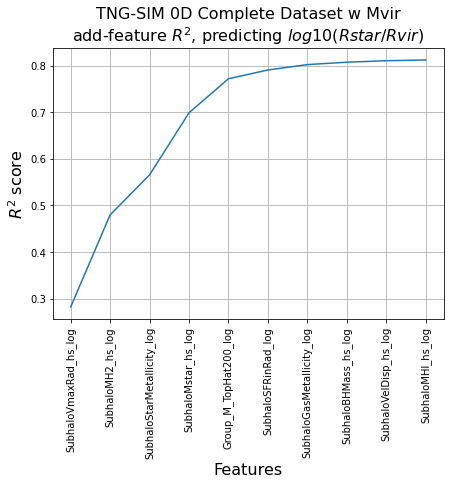

In [24]:
all_0D_fig_add_feature=RF_results_all[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,10))
all_0D_fig_add_feature.set_title(label= r'TNG-SIM 0D Complete Dataset w Mvir' + '\n' + r'add-feature $R^{2}$, predicting $log{10}(Rstar/Rvir)$',fontsize=16)
all_0D_fig_add_feature.set_xlabel('Features',fontsize=16)
all_0D_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# all_0D_fig_add_feature.get_figure().savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDataset_R_score_by_add_feature.jpg', dpi=500)

plt.show()

In [28]:
# RF_results_all[4].to_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_Max_r_scores_by_add_column_method.csv', index=False)

all_raw = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_Max_r_scores_by_add_column_method.csv')

all_raw_fig = RF_results_all[1]
# all_raw_fig.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

all_raw_fig_builtin_imp = RF_results_all[2]
# all_raw_fig_builtin_imp.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_Built_in_Feature_Ranking.jpeg', dpi=500)
plt.show()

In [26]:
all_raw

feature_number                    features  r_sq_score
0               1       SubhaloVmaxRad_hs_log    0.281845
1               2           SubhaloMH2_hs_log    0.479709
2               3  SubhaloStarMetallicity_log    0.565423
3               4         SubhaloMstar_hs_log    0.698734
4               5       Group_M_TopHat200_log    0.771796
5               6         SubhaloSFRinRad_log    0.790568
6               7   SubhaloGasMetallicity_log    0.802151
7               8        SubhaloBHMass_hs_log    0.807238
8               9       SubhaloVelDisp_hs_log    0.810483
9              10           SubhaloMHI_hs_log    0.812047

In [11]:
# y_pred_RF_df_all = RF_results_all[0]
# y_pred_RF_df_all = pd.DataFrame({'y_pred_RF SIM 0D': y_pred_RF_df_all})

# y_pred_RF_df_all.to_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv', index=False)

y_pred_RF_all = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv')

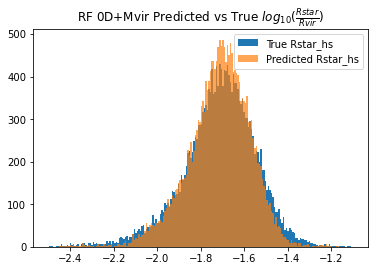

In [13]:
plt.hist(df_0D_log.SubhaloRstar_hs_log, bins=200, label='True Rstar_hs'
        , range=(-2.50, 0-1.1))
plt.hist(y_pred_RF_all.loc[:, 'y_pred_RF SIM 0D'], bins=200, alpha=0.7, label='Predicted Rstar_hs'
        , range=(-2.5, -1.1))
plt.legend(loc='upper right')
plt.title(r'RF 0D+Mvir Predicted vs True $log_{10}(\frac{Rstar}{Rvir})$')
# plt.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_Histogram_RF_pred_true_TNG-SIM_0D_AllDatasetwMvir.jpeg', dpi=500)
plt.show()

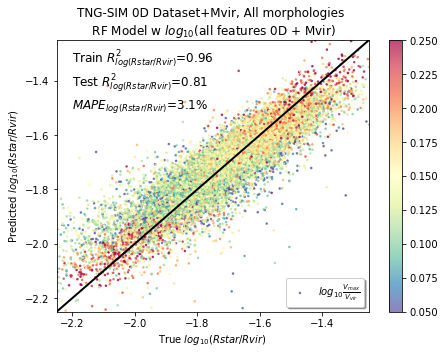

In [47]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, y_pred_RF_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.2, -1.5, r'Train $R^{2}_{log(Rstar/Rvir)}$=0.96' + '\n' + r'Test $R^{2}_{log(Rstar/Rvir)}$=0.81' + '\n' + r'$MAPE_{log(Rstar/Rvir)}$=3.1$\%$ ', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset+Mvir, All morphologies \n ' + r'RF Model w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True $log_{10}(Rstar/Rvir)$')
ax.set_ylabel(r'Predicted $log_{10}(Rstar/Rvir)$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_RF_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

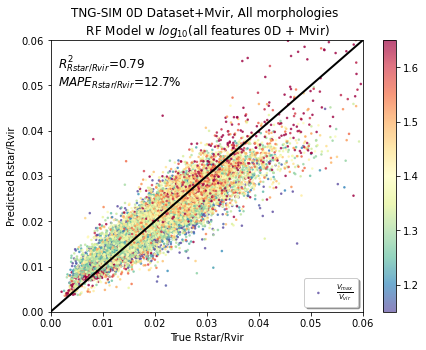

In [49]:
# Plot of Predicted Rstar/Rvir vs Rstar/Rvir 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_0D_log.SubhaloRstar_hs_log), 10**(y_pred_RF_all),
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{V_{max}}{V_{vir}}$', vmin=1.15, vmax=1.65)
ax.text(0.0015, 0.05, r'$R^{2}_{Rstar/Rvir}$=0.79' + '\n' + r'$MAPE_{Rstar/Rvir}$=12.7$\%$ ', size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset+Mvir, All morphologies \n ' + r'RF Model w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True Rstar/Rvir')
ax.set_ylabel(r'Predicted Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_RF_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

In [81]:
y_pred_RF_all

y_pred_RF SIM 0D
0             -1.594606
1             -1.525689
2             -1.579069
3             -1.722509
4             -1.594120
...                 ...
21593         -1.252864
21594         -1.422452
21595         -1.264569
21596         -1.333798
21597         -1.294597

[21598 rows x 1 columns]

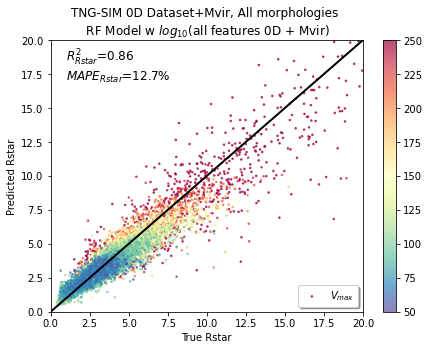

In [50]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, (10**(y_pred_RF_all.loc[:, 'y_pred_RF SIM 0D']))*df_raw.Group_R_TopHat200,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.86' + '\n' + r'$MAPE_{Rstar}$=12.7$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset+Mvir, All morphologies \n ' + r'RF Model w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_RF_size_pred_colorlogVmaxVvir_3.jpeg', dpi=500)
plt.show()

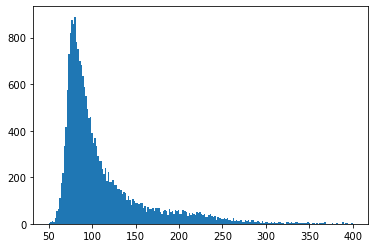

In [78]:
plt.hist(df_raw.SubhaloVmax, bins=200, range=(50,400))
plt.show()

### Other metrics

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar/Rvir) metrics

In [31]:
r2_score(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])

0.8098239512049261

In [32]:
mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])

0.005547096385183298

In [33]:
np.sqrt(mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM 0D']))

0.0744788317925523

In [34]:
mean_absolute_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])

0.05436907814102099

In [35]:
# MAPE in log scale
mean_absolute_percentage_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])

0.031676013064533506

##### <font color='darkgreen'> <a id =10> </a> <br>Rstar/Rvir metrics

In [36]:
r2_score(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D']))

0.7922480602840534

In [37]:
mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D']))

1.2760543114296571e-05

In [38]:
np.sqrt(mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])))

0.003572190240496238

In [39]:
# MAPE in original variables
mean_absolute_percentage_error(10**(df_0D_log.loc[:, 'SubhaloRstar_hs_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D']))

0.1279045143705948

##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

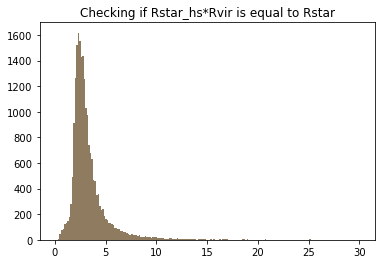

In [40]:
plt.hist(df_raw.loc[:, 'SubhaloRstar'], bins=200, range=(0,30))
plt.hist(df_0D.loc[:, 'SubhaloRstar_hs']*df_raw.Group_R_TopHat200, bins=200, range=(0,30), alpha=0.5)
plt.title('Checking if Rstar_hs*Rvir is equal to Rstar')

plt.show()

In [41]:
r2_score(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200)

0.8647040486017419

In [42]:
mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200)

1.0134199068981118

In [43]:
np.sqrt(mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200))

1.0066875915089606

In [44]:
mean_absolute_percentage_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200)

0.12790468992019002

### Learning Curve

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.8105 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
RF Accuracy: 0.81 (+/- 0.02)


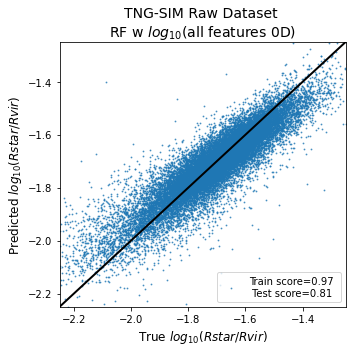

Elapsed time to compute the importances: 0.274 seconds
Elapsed time to compute the importances: 108.081 seconds


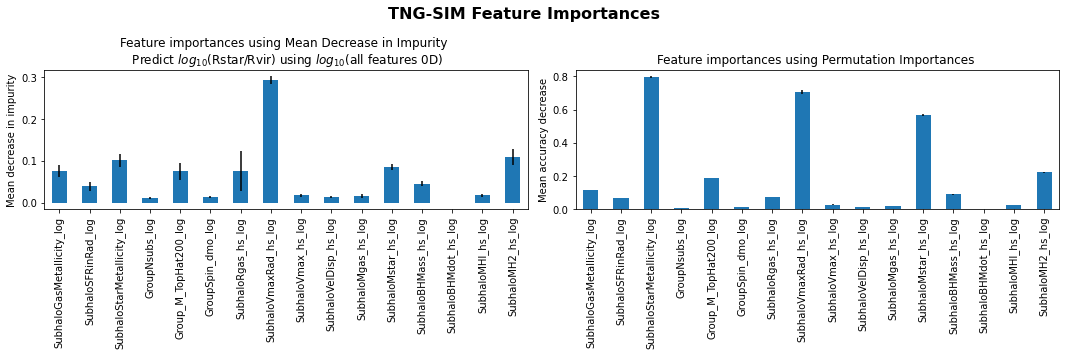

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


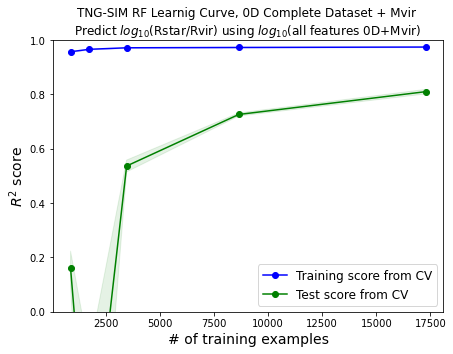

Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: 1597.126 seconds


In [51]:
# this code takes 2242.162 seconds ~37min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries 
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_all, y_all, 'TNG-SIM RF Learnig Curve, 0D Complete Dataset + Mvir \n'+r'Predict $log_{10}$(Rstar/Rvir) using $log_{10}$(all features 0D+Mvir)')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: {elapsed_time:.3f} seconds")

In [52]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_RF_Learning_Curve_zoom.jpeg', dpi=500)
lc_3 = RF_lc_2[2]
# lc_3.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_PermutationImportances.jpeg', dpi=500)
# RF_lc_2[3].to_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_PermutationImportances.csv', index=False)


### <font color='darkred'> <a id =3> </a> <br> Conclusion: Including Mvir in the 0D dataset the R2=0.86 for RandomForests, while for  0D only dataset it is R2=0.85.Therefore, the increase in performance due to the addition of Mvir is mostly present in SVR, and less in RF.
    
  

### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset w DM features only: RF & Feature Ranking

In [13]:
X_dm = df_0D_log.drop(columns=['SubhaloRstar_hs_log', 
                                'SubhaloBHMass_hs_log',
                                 'SubhaloBHMdot_hs_log',
                                 'SubhaloGasMetallicity_log',
                                 'SubhaloSFRinRad_log',
                                 'SubhaloStarMetallicity_log',
                                 'SubhaloVelDisp_hs_log',
                                 'SubhaloVmax_hs_log',
                                 'SubhaloVmaxRad_hs_log',
                                 'SubhaloRgas_hs_log',
                                 'SubhaloRstar_hs_log',
                                 'SubhaloMgas_hs_log',
                                 'SubhaloMstar_hs_log',
                             'SubhaloMHI_hs_log',
                             'SubhaloMH2_hs_log',]) # drop target and all galaxy properties

y_dm = df_0D_log.loc[:,'SubhaloRstar_hs_log']

In [14]:
X_dm.columns.to_list()

['GroupNsubs_log', 'Group_M_TopHat200_log', 'GroupSpin_dmo_log']

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.1938 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 50}
RF Accuracy: 0.19 (+/- 0.02)


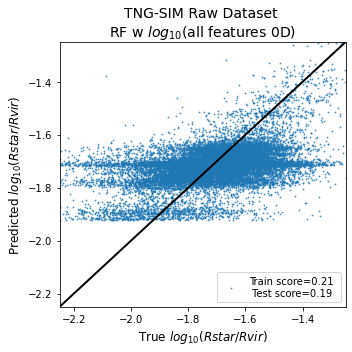

Elapsed time to compute the importances: 0.002 seconds
Elapsed time to compute the importances: 0.407 seconds


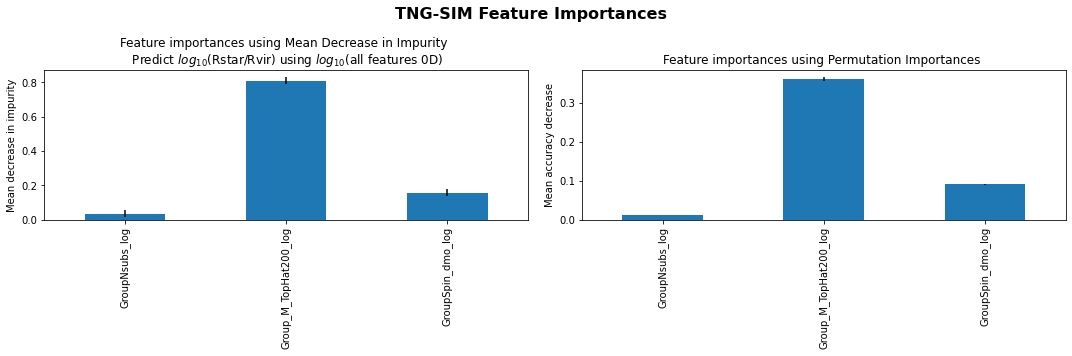

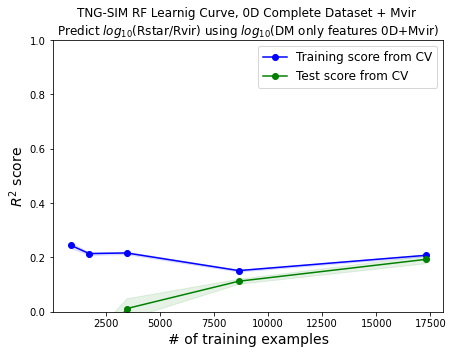

Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: 118.637 seconds


In [15]:
# this code takes 2242.162 seconds ~37min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries 
start_time = time.time()

RF_lc_dm = tp_lc_functions.target_predicting_RF_function(X_dm, y_dm, 'TNG-SIM RF Learnig Curve, 0D Complete Dataset + Mvir \n'+r'Predict $log_{10}$(Rstar/Rvir) using $log_{10}$(DM only features 0D+Mvir)')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: {elapsed_time:.3f} seconds")

In [16]:
lc_dm = RF_lc_dm[4]
# lc_dm.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_RF_Learning_Curve_zoom.jpeg', dpi=500)
lc_permutationfeat = RF_lc_dm[2]
# lc_permutationfeat.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_PermutationImportances.jpeg', dpi=500)
# RF_lc_dm[3].to_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_wDMfeatures_AllDatasetwMvir_PermutationImportances.csv', index=False)


In [18]:
y_pred_RF_df_dm = RF_lc_dm[0]
y_pred_RF_df_dm = pd.DataFrame({'y_pred_RF SIM 0D': y_pred_RF_df_dm})

# y_pred_RF_df_dm.to_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv', index=False)

# y_pred_RF_dm = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv')

In [19]:
y_pred_RF_dm

y_pred_RF SIM 0D
0             -1.481123
1             -1.516393
2             -1.611023
3             -1.548512
4             -1.551170
...                 ...
21593         -1.231383
21594         -1.216954
21595         -1.201186
21596         -1.210424
21597         -1.233010

[21598 rows x 1 columns]

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

print('r2 log(Rstar/Rvir)', r2_score(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D']))
print('MAPE log(Rstar/Rvir)', # MAPE in log scale
mean_absolute_percentage_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D']))
print('sqrtMSE log(Rstar/Rvir)', np.sqrt(mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])))

print('r2 (Rstar/Rvir)', r2_score(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])))
print('MAPE (Rstar/Rvir)', # MAPE in original variables
mean_absolute_percentage_error(10**(df_0D_log.loc[:, 'SubhaloRstar_hs_log']), 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])))
print('sqrtMSE (Rstar/Rvir)', np.sqrt(mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D']))))

print('Original r2 Rstar', r2_score(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200))
print('Original MAPE Rstar', mean_absolute_percentage_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200))
print('Original sqrtMSE Rstar', np.sqrt(mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM 0D'])*df_raw.Group_R_TopHat200)))

r2 log(Rstar/Rvir) 0.19388663977168186
MAPE log(Rstar/Rvir) 0.06664786130341886
sqrtMSE log(Rstar/Rvir) 0.15333913378737626
r2 (Rstar/Rvir) 0.21292795535041853
MAPE (Rstar/Rvir) 0.28924602689289763
sqrtMSE (Rstar/Rvir) 0.006952952774485979
Original r2 Rstar 0.6859680472192616
Original MAPE Rstar 0.2892464148571113
Original sqrtMSE Rstar 1.5336958235774585


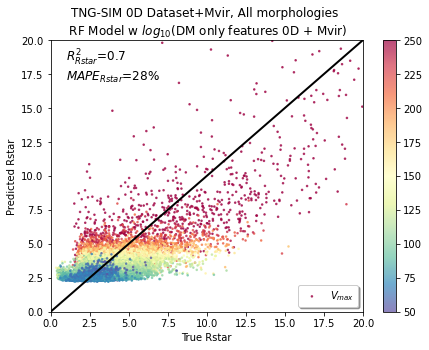

In [23]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, (10**(y_pred_RF_dm.loc[:, 'y_pred_RF SIM 0D']))*df_raw.Group_R_TopHat200,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.7' + '\n' + r'$MAPE_{Rstar}$=28$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset+Mvir, All morphologies \n ' + r'RF Model w $log_{10}$(DM only features 0D + Mvir) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_RF_size_pred_colorlogVmaxVvir_3.jpeg', dpi=500)
plt.show()